In [92]:
import numpy as np

# For plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata

import deepxde as dde
dde.backend.set_default_backend("tensorflow")
import tensorflow as tf

Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [93]:
t_max = 5

rpho = 1
mu = 1e-6

A = 1
x_min, x_max = 0, 1
y_min, y_max = 0, 1

step = 0.05
step_t = 0.1

t_points = int(t_max / step_t)
x_points = int((x_max - x_min) / step)
y_points = int((y_max - y_min) / step)

# Creation of the 2D domain (for plotting and input)
x = np.linspace(x_min, x_max, x_points)
y = np.linspace(y_min, y_max, y_points)
t = np.linspace(0, t_max, t_points)
x, y, t = np.meshgrid(x, y, t)
xyt_domain = np.hstack((x.flatten()[:, None], y.flatten()[:, None], t.flatten()[:, None]))

space_domain = dde.geometry.Rectangle([x_min, y_min], [x_max, y_max])
time_domain = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(space_domain, time_domain)

In [94]:
def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is y-coordinate
           x[:,2] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x, y, t) the speed for x component
            y[:,1] is v(x, y, t) the speed for y component
            y[:,2] is p(x, y, t) the pressure
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """
    u, v, p = y[:,0], y[:, 1], y[:, 2]
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    dv_t = dde.grad.jacobian(y, x, i=1, j=2)
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)

    d2u_x2 = dde.grad.hessian(y, x, component=0, i=0, j=0)
    d2v_x2 = dde.grad.hessian(y, x, component=1, i=0, j=0)
    d2u_y2 = dde.grad.hessian(y, x, component=0, i=1, j=1)
    d2v_y2 = dde.grad.hessian(y, x, component=1, i=1, j=1)

    f_u = du_t + u * du_x + v * du_y + 1 / rpho * dp_x - mu * (d2u_x2 + d2u_y2)
    f_v = dv_t + u * dv_x + v * dv_y + 1 / rpho * dp_y - mu * (d2v_x2 + d2v_y2)
    f_continuity = du_x + dv_y

    return [f_u, f_v, f_continuity]

In [95]:

# Boundary and Initial conditions

# Periodic Boundary conditions
bc_u_0 = dde.icbc.DirichletBC(domain, lambda x: 0, lambda _, on_boundary: on_boundary, component=0)
bc_v_0 = dde.icbc.DirichletBC(domain, lambda x: 0, lambda _, on_boundary: on_boundary, component=1)

bc_u_1 = dde.icbc.NeumannBC(domain, lambda x: 0, lambda _, on_boundary: on_boundary, component=0)
bc_v_1 = dde.icbc.NeumannBC(domain, lambda x: 0, lambda _, on_boundary: on_boundary, component=1)
# bc_p_0 = dde.icbc.DirichletBC(domain, lambda x: 1, lambda _, on_boundary: True, component=2)

# Initial conditions
def init_cond_u(x):
    return np.array([A] * len(x))

def init_cond_v(x):
    return np.array([A] * len(x))

def init_cond_p(x):
    return np.array([1] * len(x))


ic_u = dde.icbc.IC(domain, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(domain, init_cond_v, lambda _, on_initial: on_initial, component=1)
# ic_p = dde.icbc.IC(domain, init_cond_p, lambda _, on_initial: True, component=2)


In [96]:
data = dde.data.TimePDE(domain, pde, [bc_u_0, bc_v_0, bc_u_1, bc_v_1, ic_u, ic_v],
                         num_domain=x_points * y_points,
                         num_boundary=2*(x_points+y_points),
                         num_initial=x_points*y_points,
                         train_distribution="pseudo",
)

# Network architecture
net = dde.nn.FNN([3] + [16] * 4 + [3], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [97]:
# To employ a GPU accelerated system is highly encouraged.

model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=100, display_every=10)

Compiling model...
'compile' took 0.002629 s

Training model...



/home/ygrik/.conda/envs/pinn-env/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [2.48e-01, 4.60e-02, 1.38e-02, 5.12e-02, 3.53e-01, 2.86e-02, 2.81e-02, 7.24e-01, 5.26e-01]    [2.48e-01, 4.60e-02, 1.38e-02, 5.12e-02, 3.53e-01, 2.86e-02, 2.81e-02, 7.24e-01, 5.26e-01]    []  
10        [4.52e-02, 1.73e-02, 4.17e-02, 5.62e-02, 5.13e-02, 7.27e-02, 2.80e-02, 3.09e-01, 4.00e-01]    [4.52e-02, 1.73e-02, 4.17e-02, 5.62e-02, 5.13e-02, 7.27e-02, 2.80e-02, 3.09e-01, 4.00e-01]    []  
20        [1.56e-02, 3.19e-02, 5.06e-02, 7.95e-02, 4.81e-02, 8.44e-02, 4.14e-02, 1.39e-01, 1.89e-01]    [1.56e-02, 3.19e-02, 5.06e-02, 7.95e-02, 4.81e-02, 8.44e-02, 4.14e-02, 1.39e-01, 1.89e-01]    []  
30        [1.40e-02, 4.10e-02, 2.45e-02, 7.94e-02, 6.00e-02, 4.34e-02, 2.86e-02, 8.90e-02, 9.37e-02]    [1.40e-02, 4.10e-02, 2.45e-02, 7.94e-02, 6.00e-02, 4.34e-02, 2.86e-02, 8.90e-

(<deepxde.model.LossHistory at 0x719fdcdd8f10>,
 <deepxde.model.TrainState at 0x719fdc21a0a0>)

In [98]:
# dde.optimizers.config.set_LBFGS_options(
#     maxcor=50,
#     ftol=1.0 * np.finfo(float).eps,
#     gtol=1e-08,
#     maxiter=10000,
#     maxfun=10000,
#     maxls=50,
# )
# model.compile("L-BFGS")
# model.train()

In [99]:
prediction = model.predict(xyt_domain, operator=None)

u_predict = griddata(xyt_domain, prediction[:, 0], (x, y, t), method="linear")
v_predict = griddata(xyt_domain, prediction[:, 1], (x, y, t), method="linear")
p_predict = griddata(xyt_domain, prediction[:, 2], (x, y, t), method="linear")



In [100]:

# fig, ax = plt.subplots(4)

# ax[0].set_ylabel("vr part")
# vuv_quiver = ax[0].quiver(
#     np.arange(u_predict.shape[0]),
#     np.arange(u_predict.shape[1]),
#     u_predict[:,:,0].T, 
#     v_predict[:,:,0].T,
#     angles='xy', scale_units='xy', scale=1
# )

# ax[1].set_ylabel("p part")
# p_plot = ax[1].imshow(
#     p_predict[:,:,0].T,
#     interpolation="nearest",
#     cmap="viridis",
#     extent=[x_min, x_max,y_min, y_max],
#     origin="lower",
#     aspect="auto"
# )

# ax[2].set_ylabel("u part")
# u_plot = ax[2].imshow(
#     v_predict[:,:,0].T,
#     interpolation="nearest",
#     cmap="viridis",
#     extent=[x_min, x_max,y_min, y_max],
#     origin="lower",
#     aspect="auto"
# )

# ax[3].set_ylabel("v part")
# v_plot = ax[3].imshow(
#     u_predict[:,:,0].T,
#     interpolation="nearest",
#     cmap="viridis",
#     extent=[x_min, x_max,y_min, y_max],
#     origin="lower",
#     aspect="auto"
# )
# multiplier = 15
# def animate(t_curr):
#     ax[0].set_title(f"Results t={t_curr}")
#     vuv_quiver.set_UVC(multiplier * u_predict[:,:,t_curr].T, multiplier * v_predict[:,:,t_curr].T)
#     p_plot.set_array(p_predict[:,:,t_curr].T)
#     u_plot.set_array(u_predict[:,:,t_curr].T)
#     v_plot.set_array(v_predict[:,:,t_curr].T)
#     return vuv_quiver, p_plot, u_plot, v_plot

# t_curr = 0
# ani = FuncAnimation(fig, animate, frames=len(u_predict[0,0,:]), interval=100, blit=True)

# ani.save("animation.gif", writer="imagemagick", fps=10)

# plt.show()

In [101]:
# fig_u, ax_u = plt.subplots(1)

# ax_u.set_ylabel("u part")
# u_plot = ax_u.imshow(
#     v_predict[:,:,0].T,
#     interpolation="bicubic",
#     cmap="viridis",
#     extent=[x_min, x_max,y_min, y_max],
#     origin="lower",
#     aspect="auto"
# )

# fig_v, ax_v = plt.subplots(1)
# ax_v.set_ylabel("v part")
# v_plot = ax_v.imshow(
#     u_predict[:,:,0].T,
#     interpolation="bicubic",
#     cmap="viridis",
#     extent=[x_min, x_max,y_min, y_max],
#     origin="lower",
#     aspect="auto"
# )
# fig_v.colorbar(ax_v)

# multiplier = 15
# def animate_u(t_curr):
#     ax_u.set_title(f"Results t={t_curr}")
#     u_plot.set_array(u_predict[:,:,t_curr].T)
#     return u_plot,

# def animate_v(t_curr):
#     ax_v.set_title(f"Results t={t_curr}")
#     v_plot.set_array(v_predict[:,:,t_curr].T)
#     return v_plot,

# ani_u = FuncAnimation(fig_u, animate_u, frames=len(u_predict[0,0,:]), blit=True)
# ani_v = FuncAnimation(fig_v, animate_v, frames=len(v_predict[0,0,:]), blit=True)

# ani_u.save("animation_u.gif", writer="imagemagick", fps=10)
# ani_v.save("animation_v.gif", writer="imagemagick", fps=10)

# plt.show()

0.7853479385375977
0.9122808575630188


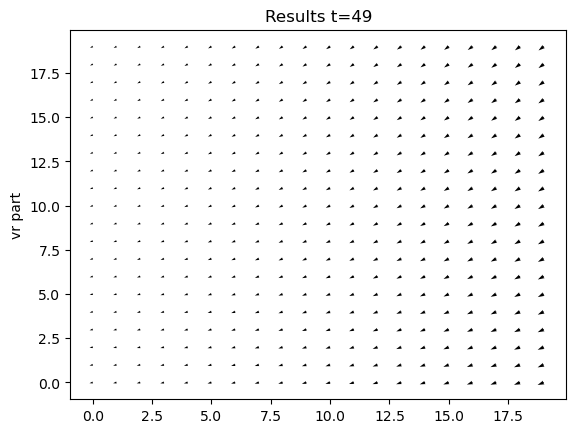

In [102]:
print(np.min(u_predict[:,:,0].T))
print(np.max(u_predict[:,:,0].T))

fig, ax = plt.subplots(1)

ax.set_ylabel("vr part")
vuv_quiver = ax.quiver(
    np.arange(u_predict.shape[0]),
    np.arange(u_predict.shape[1]),
    u_predict[:,:,0].T, 
    v_predict[:,:,0].T,
    angles='xy', scale_units='xy', scale=0.5
)

def animate(t_curr):
    ax.set_title(f"Results t={t_curr}")
    vuv_quiver.set_UVC(u_predict[:,:,t_curr].T, v_predict[:,:,t_curr].T)
    return vuv_quiver,

ani_xy = FuncAnimation(fig, animate, frames=len(v_predict[0,0,:]), blit=True)

ani_xy.save("animation_xy.gif", writer="imagemagick", fps=5)

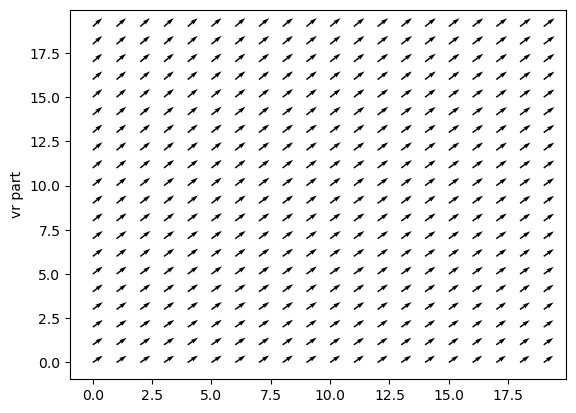

In [103]:
fig, ax = plt.subplots(1)
frame = 0
ax.set_ylabel("vr part")
vuv_quiver = ax.quiver(
    np.arange(u_predict.shape[0]),
    np.arange(u_predict.shape[1]),
    u_predict[:,:,frame].T, 
    v_predict[:,:,frame].T,
    angles='xy', scale_units='xy', scale=2
)

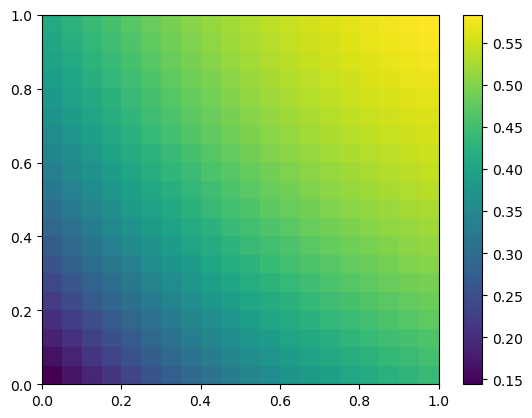

In [104]:
plt.imshow(
    p_predict[:,:,0].T,
    interpolation="nearest",
    cmap="viridis",
    extent=[x_min, x_max,y_min, y_max],
    origin="lower",
    aspect="auto"
)
plt.colorbar()

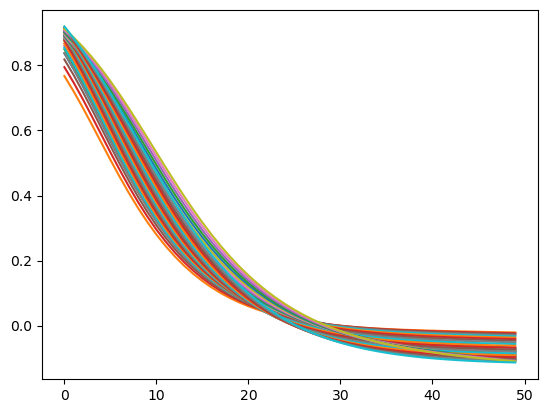

In [105]:
for i in range(u_predict.shape[0]):
    plt.plot(u_predict[i, i, :])
    plt.plot(v_predict[i, i, :])